## Importing and cleaning information for the analysis

In [1]:
# Importing Libraries
import ast # To convert the skils to a list
import pandas as pd 
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data (Job postings)
df = pd.read_csv(r"C:\Users\WIN10\Desktop\Job_Analysis_2025\Job_CSV\jobs_postings.csv")


# Data clean up
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

# Create the column month (data will be analyzed monthly)

df['job_posted_month'] = df['job_posted_date'].dt.strftime('%b')

# Filter by the year and sorting by month
df_2025 = df[df['job_posted_date'].dt.year == 2025].copy()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_2025['job_posted_month'] = pd.Categorical(
    df_2025['job_posted_month'],
    categories=month_order,
    ordered=True
)

## How well do jobs and skills pay for Data Analysts and Data Scientists?

### Metholodgy
1. Evaluate median salary for top 6 data jobs
2. Find the median salary per skill for Data Analysts and Scientists
3. Visualize for highest paying skills and most demanded skills

### Get the top 6 data jobs (by job postings)

In [2]:
# Get the top 6 data roles in Germany with the highest median salary 
df_ca = df_2025[df_2025['job_country'] == "Canada"].dropna(subset=['salary_year_avg']).copy()
job_titles = df_ca['job_title_short'].value_counts().index[:6].to_list()

### Filter our dataframe by the top 6 data jobs

In [3]:
# Get data frame for only the top 5 data jobs/roles
df_top6 = df_ca[df_ca['job_title_short'].isin(job_titles)]

# Group by job role and get the median of the salary year average
df_top6_gr = df_top6.groupby('job_title_short')['salary_year_avg'].median()

# Get the list to order our data by the median salary for top 6 data roles/jobs
sorting_list = df_top6_gr.sort_values(ascending=False).index.to_list()

# Sorting our data
df_top6['job_title_short'] = pd.Categorical(
    df_top6['job_title_short'],
    categories=sorting_list,
    ordered=True
)


### Plot with a violin chart to get the distribution of the median salary for top 6 data roles/jobs

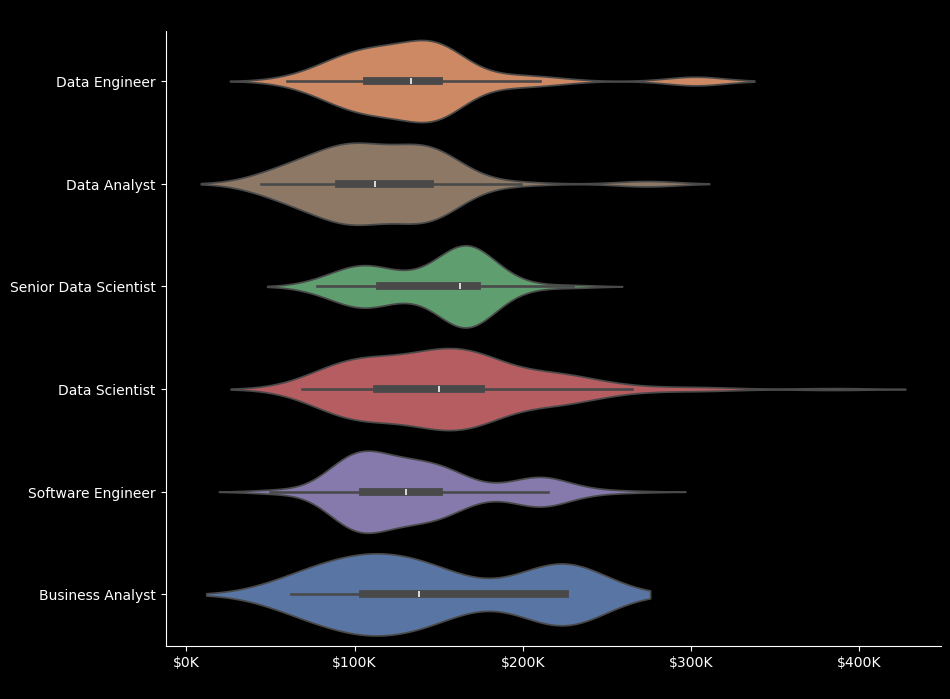

In [10]:
# Get the order for the labels/plots
order = df_top6['job_title_short'].unique()

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 8))
roles_palette = {
    "Data Analyst" : "#4C72B0",  # blue
    "Senior Data Scientist" : "#DD8452",  # orange
    "Business Analyst" : "#55A868",  # green
    "Data Engineer" : "#C44E52",  # red
    "Software Engineer" : "#8172B3",  # purple
    "Data Scientist" : "#937860"   # brown
}

# Plotting
sns.violinplot(data=df_top6, x='salary_year_avg', y='job_title_short', ax=ax, order=order, hue='job_title_short', palette=roles_palette, legend=False, dodge=False)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"${int(x/1000)}K"))
ax.set_xlabel('Median Salary')
ax.set_title('Distribution of Salaries based on Job roles in Germany')
ax.set_ylabel('')
ax.set_facecolor('black')
ax.tick_params(color='white', labelcolor='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

fig.patch.set_facecolor('black')
plt.show()

### Getting the median salary per Skill for Data Analysts/Scientist

In [11]:
# Get the dataframe for specifically Data Analysts
df_da = df_ca[df_ca['job_title_short'] == 'Data Analyst'].dropna(subset=['salary_year_avg'])

# Get the dataframe for specifically Data Scientists
df_ds = df_ca[df_ca['job_title_short'] == 'Data Scientist'].dropna(subset=['salary_year_avg'])

# Explode the skills column to get the median salary for Data Analysts
df_da_ex = df_da.explode('job_skills')

# Explode the skills column to get the median salary for Data Scientists
df_ds_ex = df_ds.explode('job_skills')

# Get the most paying skills and the most common ones for Data Analysts
df_da_most_pay = df_da_ex.groupby('job_skills')['salary_year_avg'].median().sort_values(ascending=False).head(6).to_frame()
df_da_most_common = df_da_ex.groupby('job_skills')['salary_year_avg'].agg(['size','median']).sort_values(by='size', ascending=False).head(6).sort_values(by='median', ascending=False)
# Get the most paying skills and the most common ones for Data Scientists
df_ds_most_pay = df_ds_ex.groupby('job_skills')['salary_year_avg'].median().sort_values(ascending=False).head(6).to_frame()
df_ds_most_common = df_ds_ex.groupby('job_skills')['salary_year_avg'].agg(['size','median']).sort_values(by='size', ascending=False).head(6).sort_values(by='median', ascending=False)

### Plotting most-paying and most-common skills

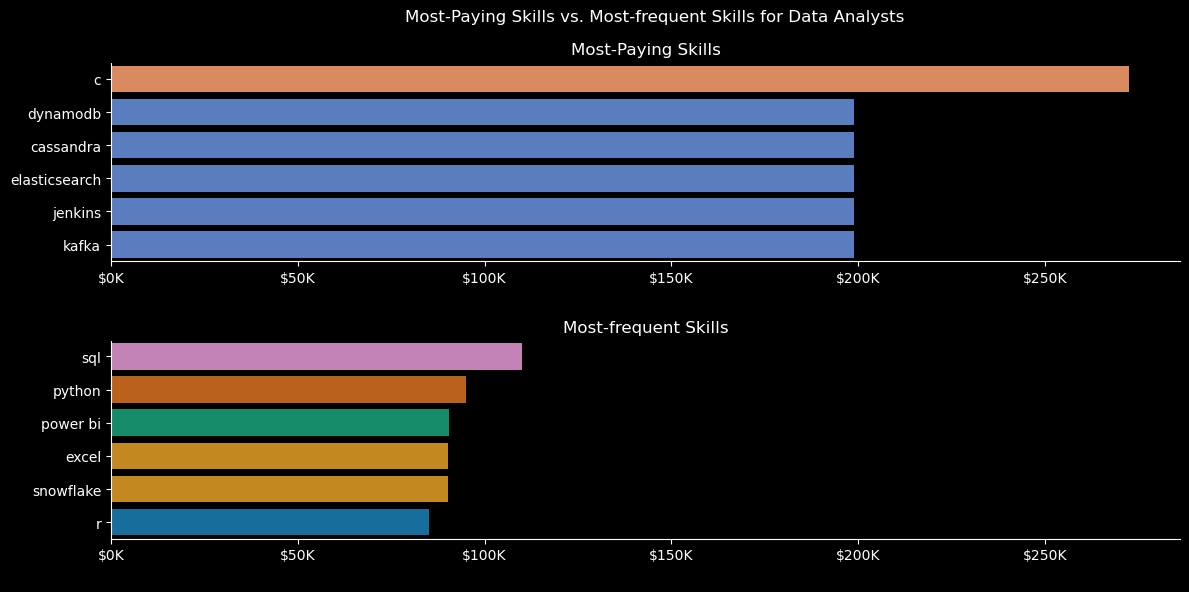

In [22]:
# Creating the plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Plotting most paying skills
sns.barplot(data=df_da_most_pay,x='salary_year_avg', y='job_skills', ax=ax[0], hue='salary_year_avg', palette='muted', legend=False)
ax[0].set_facecolor('black')
ax[0].set_ylabel('')
ax[0].tick_params(color='white', labelcolor='white')
ax[0].spines['bottom'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].set_title('Most-Paying Skills', color='white')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"${int(x/1000)}K"))

# Plotting most common skills
sns.barplot(data=df_da_most_common,x='median', y='job_skills', ax=ax[1], hue='median', palette='colorblind', legend=False)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_facecolor('black')
ax[1].set_ylabel('')
ax[1].tick_params(color='white', labelcolor='white')
ax[1].spines['bottom'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].set_title('Most-frequent Skills', color='white')
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"${int(x/1000)}K"))

fig.suptitle('Most-Paying Skills vs. Most-frequent Skills for Data Analysts', color='white', x=0.55)
fig.patch.set_facecolor('black')
fig.tight_layout()
plt.show()

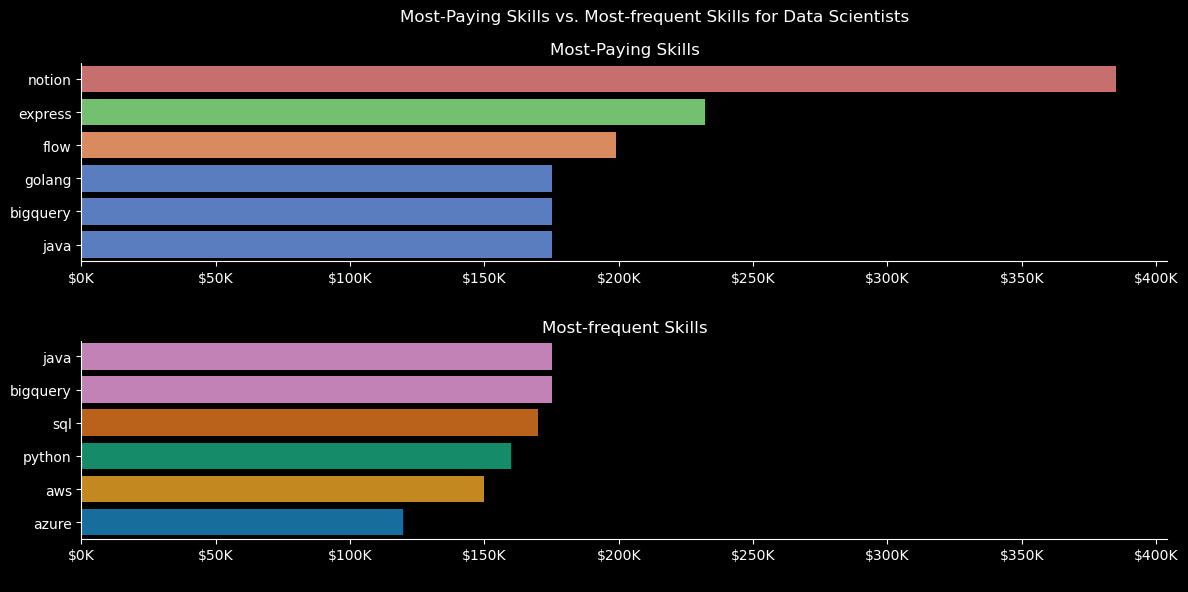

In [23]:
# Creating the plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Plotting most paying skills
sns.barplot(data=df_ds_most_pay,x='salary_year_avg', y='job_skills', ax=ax[0], hue='salary_year_avg', palette='muted', legend=False)
ax[0].set_facecolor('black')
ax[0].set_ylabel('')
ax[0].tick_params(color='white', labelcolor='white')
ax[0].spines['bottom'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].set_title('Most-Paying Skills', color='white')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"${int(x/1000)}K"))

# Plotting most common skills
sns.barplot(data=df_ds_most_common,x='median', y='job_skills', ax=ax[1], hue='median', palette='colorblind', legend=False)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_facecolor('black')
ax[1].set_ylabel('')
ax[1].tick_params(color='white', labelcolor='white')
ax[1].spines['bottom'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].set_title('Most-frequent Skills', color='white')
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"${int(x/1000)}K"))

fig.suptitle('Most-Paying Skills vs. Most-frequent Skills for Data Scientists', color='white', x=0.55)
fig.patch.set_facecolor('black')
fig.tight_layout()
plt.show()